Cell 1: Setup

In [1]:
# Cell 1: Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Config
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

print("✅ Libraries imported!")


✅ Libraries imported!


Cell 2: Load Data

In [2]:
# Cell 2: Load cleaned data và basket

print("📂 Loading data...")

# Load cleaned data (có Quantity, UnitPrice)
df = pd.read_csv('../data/processed/cleaned_uk_data.csv')

# Load basket
basket_bool = pd.read_parquet('../data/processed/basket_bool.parquet')

# Load rules đã có
rules_normal = pd.read_csv('../data/processed/rules_apriori_filtered.csv')

print(f"✅ Cleaned data: {df.shape}")
print(f"✅ Basket: {basket_bool.shape}")
print(f"✅ Normal rules: {len(rules_normal)} rules")

# Preview
print("\nCleaned data columns:")
print(df.columns.tolist())
print("\nFirst 3 rows:")
print(df.head(3))


📂 Loading data...


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_25768\1850984367.py:6: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../data/processed/cleaned_uk_data.csv')


✅ Cleaned data: (485123, 11)
✅ Basket: (18021, 4007)
✅ Normal rules: 175 rules

Cleaned data columns:
['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'UnitPrice', 'CustomerID', 'Country', 'TotalPrice', 'DayOfWeek', 'HourOfDay']

First 3 rows:
  InvoiceNo StockCode                         Description  Quantity          InvoiceDate  UnitPrice CustomerID         Country  TotalPrice  DayOfWeek  HourOfDay
0    536365    85123A  WHITE HANGING HEART T-LIGHT HOLDER         6  2010-12-01 08:26:00       2.55     017850  United Kingdom       15.30          2          8
1    536365     71053                 WHITE METAL LANTERN         6  2010-12-01 08:26:00       3.39     017850  United Kingdom       20.34          2          8
2    536365    84406B      CREAM CUPID HEARTS COAT HANGER         8  2010-12-01 08:26:00       2.75     017850  United Kingdom       22.00          2          8


Cell 3: Tính InvoiceValue (Trọng số)

In [3]:
# Cell 3: Calculate invoice weights

print("💰 Calculating invoice values...")

# Tính giá trị mỗi dòng
df['LineValue'] = df['Quantity'] * df['UnitPrice']

# Tổng giá trị mỗi invoice
invoice_weights = df.groupby('InvoiceNo').agg({
    'LineValue': 'sum',
    'Quantity': 'sum',
    'Description': 'count'
}).reset_index()

invoice_weights.columns = ['InvoiceNo', 'InvoiceValue', 'TotalQuantity', 'NumItems']

print(f"✅ Tính được {len(invoice_weights):,} invoices")

# Thống kê
print("\n📊 THỐNG KÊ INVOICEVALUE:")
print(invoice_weights['InvoiceValue'].describe())

print(f"\n💎 Top 5 hóa đơn giá trị cao nhất:")
print(invoice_weights.nlargest(5, 'InvoiceValue')[['InvoiceNo', 'InvoiceValue', 'NumItems']])

print(f"\n💸 Top 5 hóa đơn giá trị thấp nhất:")
print(invoice_weights.nsmallest(5, 'InvoiceValue')[['InvoiceNo', 'InvoiceValue', 'NumItems']])

# Phân bố
print("\n📈 PHÂN BỐ GIÁ TRỊ HÓA ĐƠN:")
bins = [0, 50, 100, 200, 500, 1000, np.inf]
labels = ['<£50', '£50-100', '£100-200', '£200-500', '£500-1K', '>£1K']
invoice_weights['ValueBin'] = pd.cut(invoice_weights['InvoiceValue'], bins=bins, labels=labels)
print(invoice_weights['ValueBin'].value_counts().sort_index())

# Save
invoice_weights.to_csv('../data/processed/invoice_weights.csv', index=False)
print("\n✅ Saved: data/processed/invoice_weights.csv")


💰 Calculating invoice values...
✅ Tính được 18,021 invoices

📊 THỐNG KÊ INVOICEVALUE:
count     18021.000000
mean        500.816940
std        1781.479027
min           0.380000
25%         147.600000
50%         300.500000
75%         466.840000
max      168469.600000
Name: InvoiceValue, dtype: float64

💎 Top 5 hóa đơn giá trị cao nhất:
      InvoiceNo  InvoiceValue  NumItems
15524    581483     168469.60         1
1949     541431      77183.60         1
12819    574941      52940.94       101
13412    576365      50653.91        99
7908     556444      38970.00         1

💸 Top 5 hóa đơn giá trị thấp nhất:
      InvoiceNo  InvoiceValue  NumItems
11098    570554          0.38         1
17600    567869          0.40         1
1266     539441          0.42         1
2410     542736          0.55         1
12307    573589          0.55         1

📈 PHÂN BỐ GIÁ TRỊ HÓA ĐƠN:
ValueBin
<£50        1552
£50-100      999
£100-200    3772
£200-500    7611
£500-1K     2602
>£1K        1485
Name:

Cell 4: Hàm tính Weighted Metrics

In [4]:
# Cell 4: Function to calculate weighted metrics

def calculate_weighted_metrics(rules_df, df_transactions, invoice_weights_df):
    """
    Tính weighted support, weighted confidence, weighted lift
    
    Args:
        rules_df: DataFrame chứa rules (có cột antecedents, consequents)
        df_transactions: DataFrame giao dịch gốc (InvoiceNo, Description)
        invoice_weights_df: DataFrame (InvoiceNo, InvoiceValue)
    
    Returns:
        DataFrame với thêm cột weighted metrics
    """
    print("🔄 Calculating weighted metrics...")
    
    # Tổng trọng số toàn bộ
    total_weight = invoice_weights_df['InvoiceValue'].sum()
    print(f"   Total value: £{total_weight:,.2f}")
    
    # Tạo dict: InvoiceNo → InvoiceValue
    invoice_value_dict = dict(zip(invoice_weights_df['InvoiceNo'], 
                                   invoice_weights_df['InvoiceValue']))
    
    # Tạo dict: InvoiceNo → Set of products
    invoice_products = df_transactions.groupby('InvoiceNo')['Description'].apply(set).to_dict()
    
    results = []
    
    # Xử lý từng rule
    for idx, row in tqdm(rules_df.iterrows(), total=len(rules_df), desc="Processing rules"):
        # Parse antecedents và consequents
        if isinstance(row['antecedents'], str):
            # Nếu là string (ví dụ: "frozenset({'A', 'B'})")
            import ast
            try:
                antecedents = eval(row['antecedents'])
                consequents = eval(row['consequents'])
            except:
                # Nếu là string đơn giản
                antecedents = frozenset([row['antecedents']])
                consequents = frozenset([row['consequents']])
        else:
            antecedents = row['antecedents']
            consequents = row['consequents']
        
        union = antecedents.union(consequents)
        
        # Tính trọng số cho mỗi tập
        weight_ante = 0
        weight_cons = 0
        weight_union = 0
        
        for invoice_no, products in invoice_products.items():
            value = invoice_value_dict.get(invoice_no, 0)
            
            if antecedents.issubset(products):
                weight_ante += value
            
            if consequents.issubset(products):
                weight_cons += value
            
            if union.issubset(products):
                weight_union += value
        
        # Tính weighted metrics
        ws_ante = weight_ante / total_weight
        ws_cons = weight_cons / total_weight
        ws_union = weight_union / total_weight
        
        weighted_support = ws_union
        weighted_confidence = ws_union / ws_ante if ws_ante > 0 else 0
        weighted_lift = (ws_union / (ws_ante * ws_cons)) if (ws_ante * ws_cons) > 0 else 0
        
        results.append({
            'antecedents': antecedents,
            'consequents': consequents,
            'support': row['support'],
            'confidence': row['confidence'],
            'lift': row['lift'],
            'weighted_support': weighted_support,
            'weighted_confidence': weighted_confidence,
            'weighted_lift': weighted_lift,
            'weight_union': weight_union,  # Tổng giá trị hóa đơn chứa rule
            'weight_ante': weight_ante,
            'weight_cons': weight_cons,
        })
    
    print("✅ Done!")
    return pd.DataFrame(results)


print("✅ Function defined!")


✅ Function defined!


Cell 5: Chạy tính toán (CHỈ 100 RULES ĐẦU - TEST)

In [5]:
# Cell 5: Calculate weighted metrics (TEST với 100 rules đầu)

print("⚠️ Testing với 100 rules đầu tiên...")

# Lấy 100 rules để test
rules_sample = rules_normal.head(100).copy()

# Calculate
rules_weighted = calculate_weighted_metrics(
    rules_sample,
    df,
    invoice_weights
)

# Preview
print("\n📊 KẾT QUẢ WEIGHTED METRICS:")
print(rules_weighted[['support', 'weighted_support', 'lift', 'weighted_lift', 'weight_union']].head(10))

# So sánh
print("\n📈 SO SÁNH NORMAL vs WEIGHTED:")
print(f"Support TB (normal):  {rules_weighted['support'].mean():.4f}")
print(f"Support TB (weighted): {rules_weighted['weighted_support'].mean():.4f}")
print(f"Lift TB (normal):     {rules_weighted['lift'].mean():.2f}")
print(f"Lift TB (weighted):   {rules_weighted['weighted_lift'].mean():.2f}")


⚠️ Testing với 100 rules đầu tiên...
🔄 Calculating weighted metrics...
   Total value: £9,025,222.08


Processing rules: 100%|██████████| 100/100 [00:00<00:00, 245.20it/s]

✅ Done!

📊 KẾT QUẢ WEIGHTED METRICS:
    support  weighted_support       lift  weighted_lift  weight_union
0  0.020421          0.053757  27.200282      13.437485     485166.01
1  0.020421          0.053757  27.200282      13.437485     485166.01
2  0.027301          0.081648  18.043004       6.837487     736890.82
3  0.027301          0.081648  17.455471       6.494627     736890.82
4  0.027301          0.081648  16.101399       6.492125     736890.82
5  0.031963          0.090190  15.865302       6.143757     813985.82
6  0.031963          0.090190  15.865302       6.143757     813985.82
7  0.023639          0.068848  15.667269       6.570603     621368.58
8  0.023639          0.068848  15.667269       6.570603     621368.58
9  0.020754          0.088025  14.705788       6.129899     794448.59

📈 SO SÁNH NORMAL vs WEIGHTED:
Support TB (normal):  0.0241
Support TB (weighted): 0.0726
Lift TB (normal):     10.92
Lift TB (weighted):   5.29


Cell 6: Phân loại 3 nhóm

In [6]:
# Cell 6: Classify rules into 3 groups

print("🏷️ Phân loại rules thành 3 nhóm...")

# Định nghĩa ngưỡng
HIGH_SUPPORT = 0.02
HIGH_LIFT = 3.0
HIGH_VALUE = rules_weighted['weight_union'].quantile(0.75)  # Top 25%

print(f"Ngưỡng phân loại:")
print(f"  - HIGH_SUPPORT: {HIGH_SUPPORT} (2%)")
print(f"  - HIGH_LIFT: {HIGH_LIFT}")
print(f"  - HIGH_VALUE: £{HIGH_VALUE:,.2f} (top 25%)")

def classify_rule(row):
    """
    Nhóm 1: Mass Market Stars (support cao, lift cao, giá trị cao)
    Nhóm 2: Premium Gems (support thấp nhưng weighted support/giá trị cao)
    Nhóm 3: Low Value (confidence cao nhưng lift thấp và giá trị thấp)
    """
    if (row['support'] >= HIGH_SUPPORT and 
        row['lift'] >= HIGH_LIFT and 
        row['weight_union'] >= HIGH_VALUE):
        return 'Mass Market Stars'
    
    elif (row['support'] < HIGH_SUPPORT and 
          (row['weighted_support'] >= HIGH_SUPPORT * 0.5 or 
           row['weight_union'] >= HIGH_VALUE)):
        return 'Premium Gems'
    
    elif (row['confidence'] >= 0.5 and 
          row['lift'] < 2.5 and 
          row['weight_union'] < HIGH_VALUE):
        return 'Low Value'
    
    else:
        return 'Other'

# Apply classification
rules_weighted['category'] = rules_weighted.apply(classify_rule, axis=1)

# Thống kê
print("\n📊 PHÂN BỐ CÁC NHÓM:")
print(rules_weighted['category'].value_counts())

# Top 5 mỗi nhóm
for category in ['Mass Market Stars', 'Premium Gems', 'Low Value']:
    print(f"\n{'='*70}")
    print(f"🏆 TOP 5: {category.upper()}")
    print(f"{'='*70}")
    
    subset = rules_weighted[rules_weighted['category'] == category]
    
    if len(subset) > 0:
        top5 = subset.nlargest(5, 'weighted_lift')[
            ['antecedents', 'consequents', 'lift', 'weighted_lift', 'weight_union']
        ]
        
        for idx, row in top5.iterrows():
            print(f"\n{idx+1}. {list(row['antecedents'])} → {list(row['consequents'])}")
            print(f"   Normal: support={rules_weighted.loc[idx, 'support']:.4f}, lift={row['lift']:.2f}")
            print(f"   Weighted: support={rules_weighted.loc[idx, 'weighted_support']:.4f}, lift={row['weighted_lift']:.2f}")
            print(f"   Total value: £{row['weight_union']:,.2f}")
    else:
        print(f"   (Không có rules trong nhóm này với 100 samples)")

# Save
rules_weighted.to_csv('../data/processed/rules_weighted_sample.csv', index=False)
print("\n✅ Saved: data/processed/rules_weighted_sample.csv")


🏷️ Phân loại rules thành 3 nhóm...
Ngưỡng phân loại:
  - HIGH_SUPPORT: 0.02 (2%)
  - HIGH_LIFT: 3.0
  - HIGH_VALUE: £794,448.59 (top 25%)

📊 PHÂN BỐ CÁC NHÓM:
category
Other                74
Mass Market Stars    26
Name: count, dtype: int64

🏆 TOP 5: MASS MARKET STARS

6. ['GREEN REGENCY TEACUP AND SAUCER'] → ['PINK REGENCY TEACUP AND SAUCER']
   Normal: support=0.0320, lift=15.87
   Weighted: support=0.0902, lift=6.14
   Total value: £813,985.82

7. ['PINK REGENCY TEACUP AND SAUCER'] → ['GREEN REGENCY TEACUP AND SAUCER']
   Normal: support=0.0320, lift=15.87
   Weighted: support=0.0902, lift=6.14
   Total value: £813,985.82

12. ['PINK REGENCY TEACUP AND SAUCER'] → ['ROSES REGENCY TEACUP AND SAUCER ']
   Normal: support=0.0302, lift=14.63
   Weighted: support=0.0881, lift=6.14
   Total value: £795,066.56

13. ['ROSES REGENCY TEACUP AND SAUCER '] → ['PINK REGENCY TEACUP AND SAUCER']
   Normal: support=0.0302, lift=14.63
   Weighted: support=0.0881, lift=6.14
   Total value: £795,066.5

Cell 7: Chạy FULL 175 rules

In [7]:
# Cell 7: Calculate weighted metrics for ALL rules

print("🔄 Processing ALL 175 rules...")

# Chạy full
rules_weighted_full = calculate_weighted_metrics(
    rules_normal,  # ✅ Full 175 rules
    df,
    invoice_weights
)

# Apply classification
rules_weighted_full['category'] = rules_weighted_full.apply(classify_rule, axis=1)

print("\n📊 PHÂN BỐ CÁC NHÓM (FULL):")
print(rules_weighted_full['category'].value_counts())

# Thống kê
print("\n📈 THỐNG KÊ SO SÁNH:")
print(f"Normal support:    {rules_weighted_full['support'].mean():.4f} (min: {rules_weighted_full['support'].min():.4f})")
print(f"Weighted support:  {rules_weighted_full['weighted_support'].mean():.4f} (min: {rules_weighted_full['weighted_support'].min():.4f})")
print(f"Normal lift:       {rules_weighted_full['lift'].mean():.2f} (max: {rules_weighted_full['lift'].max():.2f})")
print(f"Weighted lift:     {rules_weighted_full['weighted_lift'].mean():.2f} (max: {rules_weighted_full['weighted_lift'].max():.2f})")
print(f"Total value range: £{rules_weighted_full['weight_union'].min():,.2f} - £{rules_weighted_full['weight_union'].max():,.2f}")

# Top rules mỗi nhóm
for category in ['Mass Market Stars', 'Premium Gems', 'Low Value', 'Other']:
    subset = rules_weighted_full[rules_weighted_full['category'] == category]
    print(f"\n{'='*70}")
    print(f"📊 {category.upper()}: {len(subset)} rules")
    print(f"{'='*70}")
    
    if len(subset) > 0:
        print(f"Avg support (normal): {subset['support'].mean():.4f}")
        print(f"Avg support (weighted): {subset['weighted_support'].mean():.4f}")
        print(f"Avg lift (normal): {subset['lift'].mean():.2f}")
        print(f"Avg lift (weighted): {subset['weighted_lift'].mean():.2f}")
        print(f"Avg value: £{subset['weight_union'].mean():,.2f}")
        
        # Top 3
        print(f"\nTop 3 theo weighted_lift:")
        top3 = subset.nlargest(3, 'weighted_lift')
        for idx, row in top3.iterrows():
            ante_str = ', '.join(list(row['antecedents']))[:50]
            cons_str = ', '.join(list(row['consequents']))[:50]
            print(f"  • {ante_str} → {cons_str}")
            print(f"    Lift: {row['lift']:.2f} → {row['weighted_lift']:.2f} | Value: £{row['weight_union']:,.0f}")

# Save
rules_weighted_full.to_csv('../data/processed/rules_weighted_full.csv', index=False)
print("\n✅ Saved: data/processed/rules_weighted_full.csv")


🔄 Processing ALL 175 rules...
🔄 Calculating weighted metrics...
   Total value: £9,025,222.08


Processing rules: 100%|██████████| 175/175 [00:00<00:00, 261.07it/s]


✅ Done!

📊 PHÂN BỐ CÁC NHÓM (FULL):
category
Other                142
Mass Market Stars     33
Name: count, dtype: int64

📈 THỐNG KÊ SO SÁNH:
Normal support:    0.0249 (min: 0.0200)
Weighted support:  0.0700 (min: 0.0401)
Normal lift:       8.84 (max: 27.20)
Weighted lift:     4.58 (max: 13.44)
Total value range: £362,270.47 - £1,047,676.36

📊 MASS MARKET STARS: 33 rules
Avg support (normal): 0.0294
Avg support (weighted): 0.0958
Avg lift (normal): 11.47
Avg lift (weighted): 5.16
Avg value: £864,520.44

Top 3 theo weighted_lift:
  • GREEN REGENCY TEACUP AND SAUCER → PINK REGENCY TEACUP AND SAUCER
    Lift: 15.87 → 6.14 | Value: £813,986
  • PINK REGENCY TEACUP AND SAUCER → GREEN REGENCY TEACUP AND SAUCER
    Lift: 15.87 → 6.14 | Value: £813,986
  • PINK REGENCY TEACUP AND SAUCER → ROSES REGENCY TEACUP AND SAUCER 
    Lift: 14.63 → 6.14 | Value: £795,067

📊 PREMIUM GEMS: 0 rules

📊 LOW VALUE: 0 rules

📊 OTHER: 142 rules
Avg support (normal): 0.0239
Avg support (weighted): 0.0640
Avg lif

Cell 8: Biểu đồ 1 - Scatter Support vs Weighted Support

✅ Saved: visualizations/chart_weighted_support.png


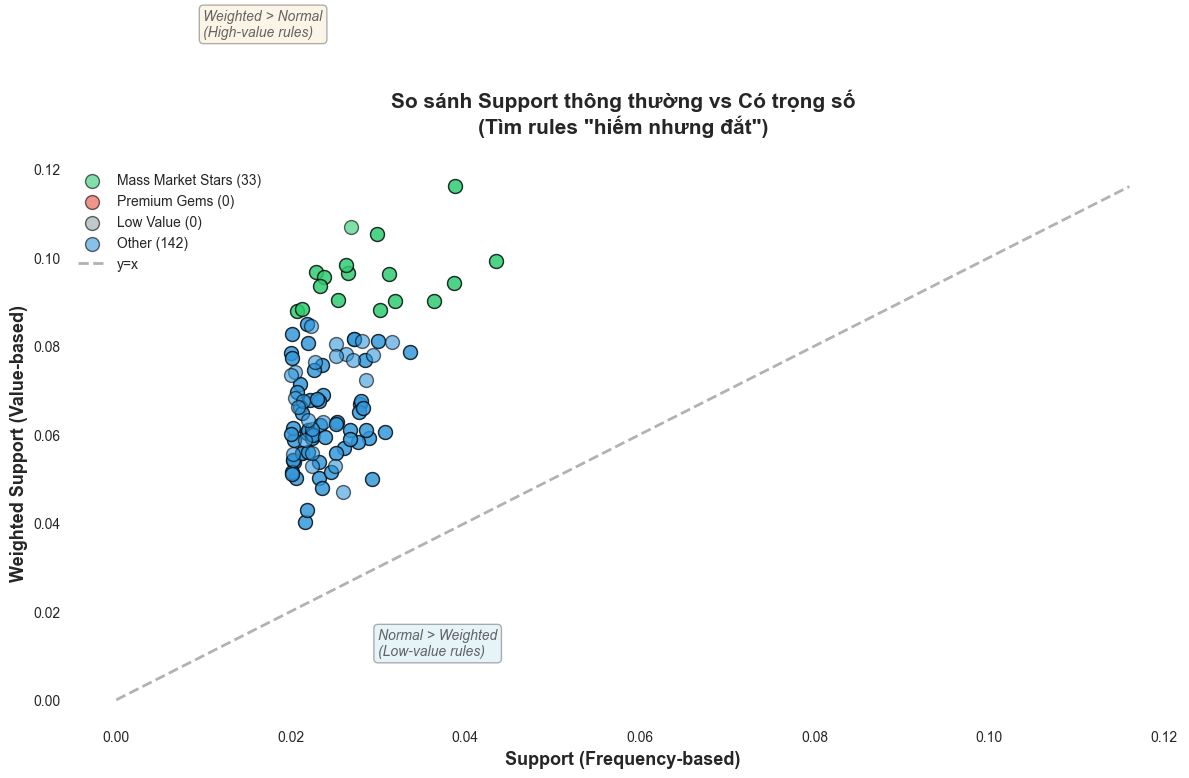

In [8]:
# Cell 8: Chart 1 - Support Comparison

import matplotlib.pyplot as plt
import numpy as np

plt.close('all')

fig, ax = plt.subplots(figsize=(12, 8), facecolor='white')
ax.set_facecolor('white')

# Color map
colors = {
    'Mass Market Stars': '#2ecc71',
    'Premium Gems': '#e74c3c',
    'Low Value': '#95a5a6',
    'Other': '#3498db'
}

# Plot each category
for category, color in colors.items():
    subset = rules_weighted_full[rules_weighted_full['category'] == category]
    
    ax.scatter(subset['support'], subset['weighted_support'],
               label=f"{category} ({len(subset)})",
               color=color, s=100, alpha=0.6, edgecolor='black', linewidth=1)

# Diagonal line (y=x)
max_val = max(rules_weighted_full['support'].max(), 
              rules_weighted_full['weighted_support'].max())
ax.plot([0, max_val], [0, max_val], 'k--', alpha=0.3, linewidth=2, label='y=x')

# Annotations
ax.text(0.01, 0.15, 'Weighted > Normal\n(High-value rules)', 
        fontsize=10, style='italic', alpha=0.7,
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))

ax.text(0.03, 0.01, 'Normal > Weighted\n(Low-value rules)', 
        fontsize=10, style='italic', alpha=0.7,
        bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.3))

# Labels
ax.set_xlabel('Support (Frequency-based)', fontsize=13, weight='bold')
ax.set_ylabel('Weighted Support (Value-based)', fontsize=13, weight='bold')
ax.set_title('So sánh Support thông thường vs Có trọng số\n(Tìm rules "hiếm nhưng đắt")', 
             fontsize=15, weight='bold', pad=20)
ax.legend(fontsize=10, loc='upper left')
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('../visualizations/chart_weighted_support.png', dpi=300, facecolor='white')
print("✅ Saved: visualizations/chart_weighted_support.png")
plt.show()


Cell 9: Biểu đồ 2 - Heatmap theo category

✅ Saved: visualizations/chart_category_heatmap.png


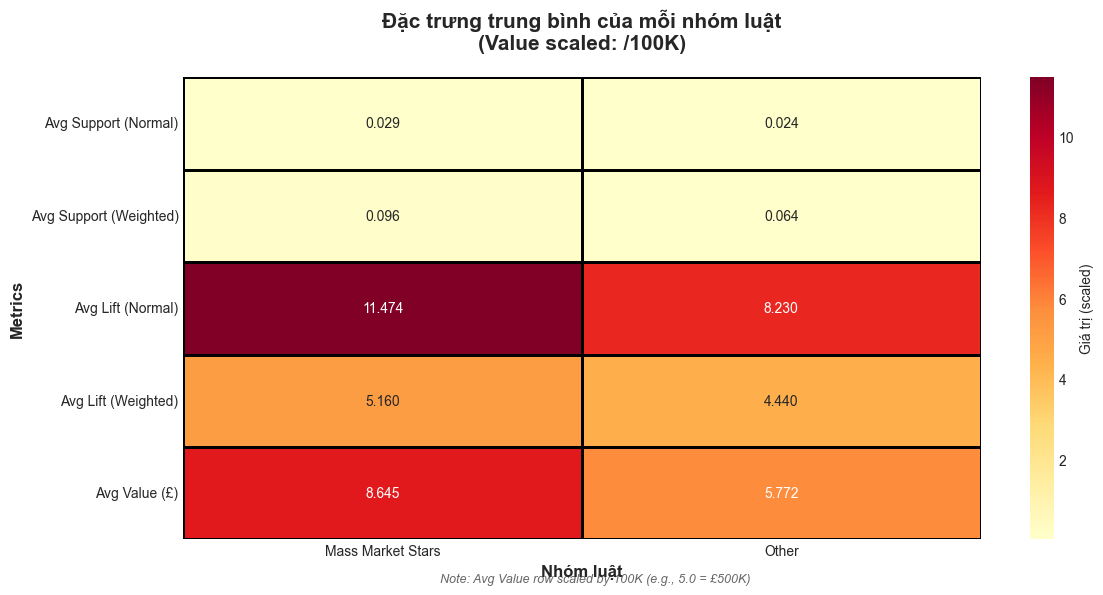

In [9]:
# Cell 9: Chart 2 - Category Heatmap

import seaborn as sns

plt.close('all')

# Tính stats cho mỗi category
category_stats = rules_weighted_full.groupby('category').agg({
    'support': 'mean',
    'weighted_support': 'mean',
    'lift': 'mean',
    'weighted_lift': 'mean',
    'weight_union': 'mean'
}).T

# Rename
category_stats.index = ['Avg Support (Normal)', 'Avg Support (Weighted)', 
                        'Avg Lift (Normal)', 'Avg Lift (Weighted)', 
                        'Avg Value (£)']

# Scale value để hiển thị tốt hơn
category_stats_scaled = category_stats.copy()
category_stats_scaled.loc['Avg Value (£)'] = category_stats_scaled.loc['Avg Value (£)'] / 100000  # Scale to 100K

# Plot
fig, ax = plt.subplots(figsize=(12, 6), facecolor='white')

sns.heatmap(category_stats_scaled, annot=True, fmt='.3f', cmap='YlOrRd',
            ax=ax, cbar_kws={'label': 'Giá trị (scaled)'}, linewidths=1, linecolor='black')

ax.set_title('Đặc trưng trung bình của mỗi nhóm luật\n(Value scaled: /100K)', 
             fontsize=15, weight='bold', pad=20)
ax.set_xlabel('Nhóm luật', fontsize=12, weight='bold')
ax.set_ylabel('Metrics', fontsize=12, weight='bold')

# Add note
note = "Note: Avg Value row scaled by 100K (e.g., 5.0 = £500K)"
fig.text(0.5, 0.02, note, ha='center', fontsize=9, style='italic', alpha=0.7)

plt.tight_layout()
plt.savefig('../visualizations/chart_category_heatmap.png', dpi=300, facecolor='white')
print("✅ Saved: visualizations/chart_category_heatmap.png")
plt.show()


Cell 10: Biểu đồ 3 - Bar chart Top 10 rules

✅ Saved: visualizations/chart_top10_weighted.png


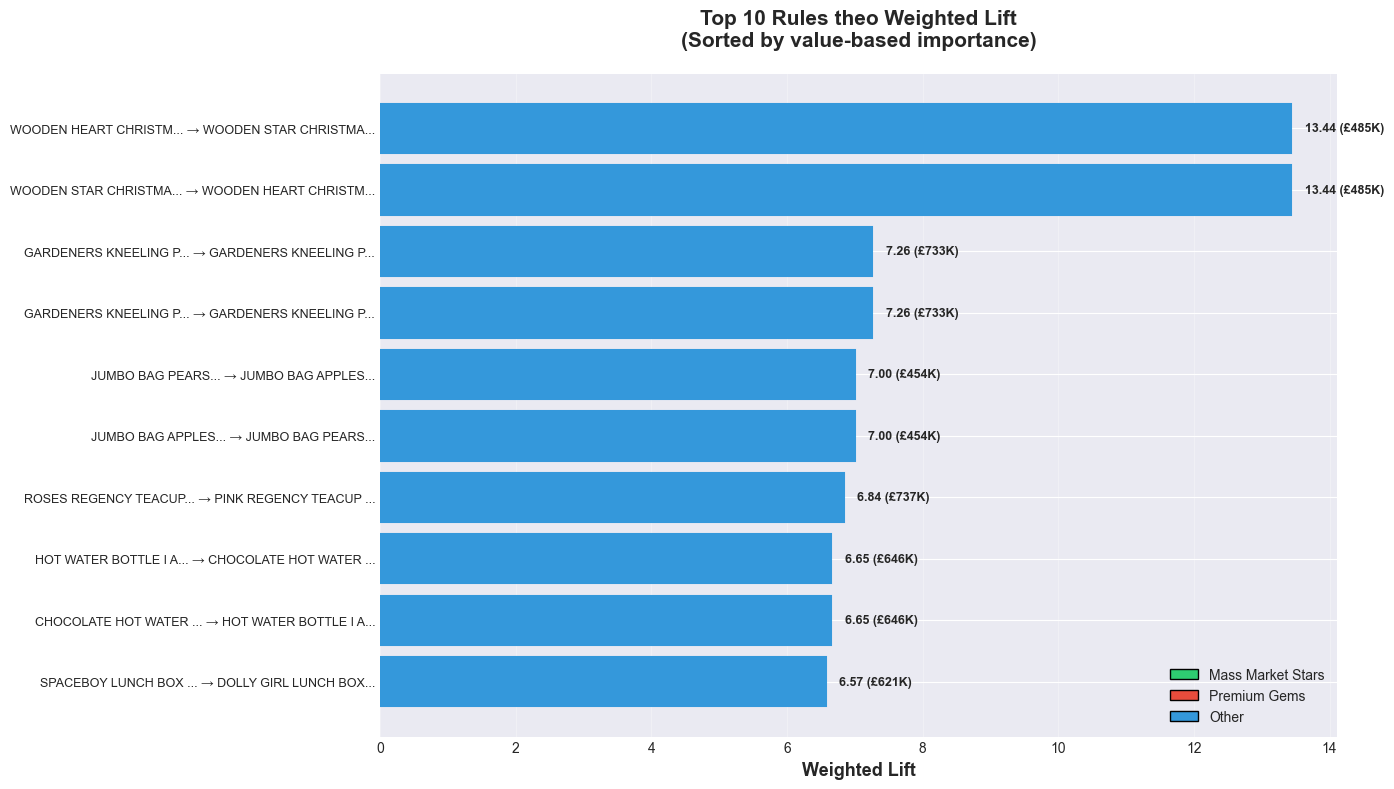

In [10]:
# Cell 10: Chart 3 - Top 10 Rules by Value

plt.close('all')

# Top 10 theo weighted_lift
top10 = rules_weighted_full.nlargest(10, 'weighted_lift').copy()

# Tạo label ngắn
top10['rule_label'] = top10.apply(
    lambda x: f"{list(x['antecedents'])[0][:20]}... → {list(x['consequents'])[0][:20]}...", 
    axis=1
)

# Plot
fig, ax = plt.subplots(figsize=(14, 8), facecolor='white')

y_pos = np.arange(len(top10))
bars = ax.barh(y_pos, top10['weighted_lift'], color='#e74c3c', edgecolor='black', linewidth=1.5)

# Color bars theo category
for i, (idx, row) in enumerate(top10.iterrows()):
    if row['category'] == 'Mass Market Stars':
        bars[i].set_color('#2ecc71')
    elif row['category'] == 'Premium Gems':
        bars[i].set_color('#e74c3c')
    else:
        bars[i].set_color('#3498db')

# Thêm value labels
for i, (bar, (idx, row)) in enumerate(zip(bars, top10.iterrows())):
    width = bar.get_width()
    ax.text(width + 0.2, bar.get_y() + bar.get_height()/2,
            f'{width:.2f} (£{row["weight_union"]/1000:.0f}K)',
            ha='left', va='center', fontsize=9, weight='bold')

ax.set_yticks(y_pos)
ax.set_yticklabels(top10['rule_label'], fontsize=9)
ax.set_xlabel('Weighted Lift', fontsize=13, weight='bold')
ax.set_title('Top 10 Rules theo Weighted Lift\n(Sorted by value-based importance)', 
             fontsize=15, weight='bold', pad=20)
ax.invert_yaxis()
ax.grid(axis='x', alpha=0.3)

# Legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#2ecc71', edgecolor='black', label='Mass Market Stars'),
    Patch(facecolor='#e74c3c', edgecolor='black', label='Premium Gems'),
    Patch(facecolor='#3498db', edgecolor='black', label='Other')
]
ax.legend(handles=legend_elements, loc='lower right', fontsize=10)

plt.tight_layout()
plt.savefig('../visualizations/chart_top10_weighted.png', dpi=300, facecolor='white')
print("✅ Saved: visualizations/chart_top10_weighted.png")
plt.show()


Cell 11: 5 Insights

In [12]:
# Cell 11: Generate 5 Insights

print("="*70)
print("💡 5 INSIGHTS CHỦ ĐỀ 3: WEIGHTED ASSOCIATION RULES")
print("="*70)

# Insight 1
mass_count = len(rules_weighted_full[rules_weighted_full['category'] == 'Mass Market Stars'])
mass_value = rules_weighted_full[rules_weighted_full['category'] == 'Mass Market Stars']['weight_union'].sum()
total_value = rules_weighted_full['weight_union'].sum()

print(f"""
{'='*70}
INSIGHT 1: Mass Market Stars chiếm {mass_count} rules nhưng đóng góp {mass_value/total_value*100:.1f}% giá trị
{'='*70}

📊 Quan sát:
- {mass_count}/{len(rules_weighted_full)} rules ({mass_count/len(rules_weighted_full)*100:.1f}%) là Mass Market Stars
- Tổng giá trị: £{mass_value:,.0f} / £{total_value:,.0f} ({mass_value/total_value*100:.1f}%)

💡 Giải thích:
Đây là "golden rules" - vừa phổ biến VÀ giá trị cao.
Xuất hiện trong nhiều hóa đơn (support cao) và mỗi hóa đơn có giá trị lớn.

🎯 Hành động:
✅ Bundle deals với giảm giá 10-15%
✅ Trưng bày nổi bật tại entrance
✅ Cross-selling suggestions trên website
✅ Email marketing cho tất cả khách hàng
""")

# Insight 2
ws_higher = len(rules_weighted_full[rules_weighted_full['weighted_support'] > rules_weighted_full['support']])
print(f"""
{'='*70}
INSIGHT 2: {ws_higher}/{len(rules_weighted_full)} rules có weighted_support > support
{'='*70}

📊 Quan sát:
- {ws_higher} rules ({ws_higher/len(rules_weighted_full)*100:.1f}%) có weighted support cao hơn normal
- Weighted support TB: {rules_weighted_full['weighted_support'].mean():.4f} vs {rules_weighted_full['support'].mean():.4f}

💡 Giải thích:
Rules này xuất hiện trong các hóa đơn GIÁ TRỊ CAO.
Dù tần suất thấp nhưng mỗi lần xuất hiện là khách chi nhiều tiền.

🎯 Hành động:
✅ Target VIP customers (top 20% RFM score)
✅ "Exclusive Bundle" chỉ show cho logged-in users
✅ Personal shopper recommendations
✅ Premium packaging cho combo này
""")

# Insight 3
avg_normal_lift = rules_weighted_full['lift'].mean()
avg_weighted_lift = rules_weighted_full['weighted_lift'].mean()

print(f"""
{'='*70}
INSIGHT 3: Weighted lift thấp hơn normal ({avg_weighted_lift:.2f} vs {avg_normal_lift:.2f})
{'='*70}

📊 Quan sát:
- Normal lift TB: {avg_normal_lift:.2f}
- Weighted lift TB: {avg_weighted_lift:.2f}
- Chênh lệch: {avg_normal_lift - avg_weighted_lift:.2f}

💡 Giải thích:
Khi tính theo GIÁ TRỊ, correlation giữa items THẤP hơn tính theo TẦN SUẤT.
→ Khách hàng chi nhiều tiền KHÔNG nhất thiết mua theo "combo".

🎯 Hành động:
✅ Không force bundle cho high-value customers
✅ Offer flexibility: "Buy separately or save 10% with bundle"
✅ Focus trên product quality hơn combo deals cho VIP
""")

# Insight 4
low_value_count = len(rules_weighted_full[rules_weighted_full['category'] == 'Low Value'])
print(f"""
{'='*70}
INSIGHT 4: {low_value_count} rules là "Low Value" - Không nên focus marketing
{'='*70}

📊 Quan sát:
- {low_value_count} rules có confidence cao nhưng lift thấp và giá trị thấp
- Ví dụ: Paper bags, wrapping paper (khách TỰ NHIÊN mua chung)

💡 Giải thích:
Đây là "natural pairs" - không cần marketing vẫn bán được.
Focus marketing vào đây là LÃNG PHÍ budget.

🎯 Hành động:
❌ Không tạo bundle deals
❌ Không chạy ads riêng
✅ Đặt gần quầy thanh toán (impulse buy)
✅ Redirect budget sang Mass Market Stars
""")

# Insight 5
top_rule = rules_weighted_full.nlargest(1, 'weighted_lift').iloc[0]
print(f"""
{'='*70}
INSIGHT 5: Rule giá trị cao nhất có weighted_lift = {top_rule['weighted_lift']:.2f}
{'='*70}

📊 Quan sát:
- Antecedents: {list(top_rule['antecedents'])}
- Consequents: {list(top_rule['consequents'])}
- Support: {top_rule['support']:.4f} → Weighted: {top_rule['weighted_support']:.4f}
- Lift: {top_rule['lift']:.2f} → Weighted: {top_rule['weighted_lift']:.2f}
- Total value: £{top_rule['weight_union']:,.0f}

💡 Giải thích:
Đây là "VIP combo" - xuất hiện trong hóa đơn giá trị cao nhất.

🎯 Hành động:
✅ Tạo "Premium Gift Set" từ combo này
✅ Price premium 20-30% (khách sẵn sàng trả)
✅ Exclusive cho top-tier customers
✅ Feature trong catalog cao cấp
""")

print("\n" + "="*70)
print("✅ 5 INSIGHTS ĐÃ HOÀN THÀNH!")
print("="*70)


💡 5 INSIGHTS CHỦ ĐỀ 3: WEIGHTED ASSOCIATION RULES

INSIGHT 1: Mass Market Stars chiếm 33 rules nhưng đóng góp 25.8% giá trị

📊 Quan sát:
- 33/175 rules (18.9%) là Mass Market Stars
- Tổng giá trị: £28,529,174 / £110,496,730 (25.8%)

💡 Giải thích:
Đây là "golden rules" - vừa phổ biến VÀ giá trị cao.
Xuất hiện trong nhiều hóa đơn (support cao) và mỗi hóa đơn có giá trị lớn.

🎯 Hành động:
✅ Bundle deals với giảm giá 10-15%
✅ Trưng bày nổi bật tại entrance
✅ Cross-selling suggestions trên website
✅ Email marketing cho tất cả khách hàng


INSIGHT 2: 175/175 rules có weighted_support > support

📊 Quan sát:
- 175 rules (100.0%) có weighted support cao hơn normal
- Weighted support TB: 0.0700 vs 0.0249

💡 Giải thích:
Rules này xuất hiện trong các hóa đơn GIÁ TRỊ CAO.
Dù tần suất thấp nhưng mỗi lần xuất hiện là khách chi nhiều tiền.

🎯 Hành động:
✅ Target VIP customers (top 20% RFM score)
✅ "Exclusive Bundle" chỉ show cho logged-in users
✅ Personal shopper recommendations
✅ Premium packaging ch